In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
sess = tf.InteractiveSession()

# Linear model for regression

For $n$ samples $(x_i, y_i)_{i=1,\ldots, n}$ :
$$ y_i = w_1 x_i + w_0 $$ 

In [2]:
n_samples = 100
sample_xs = tf.constant(
    value=np.random.uniform(low=0, high=1, size=(n_samples, 1)), 
    name='features')
sample_xs

<tf.Tensor 'features:0' shape=(100, 1) dtype=float64>

In [3]:
sample_noises = tf.constant(
    value=np.random.normal(loc=0, scale=.5, size=n_samples),
    shape=(n_samples, 1)
)

d = 2
oracle_w = np.array([1., -2.]).reshape((d, 1))

sample_ys = oracle_w[0] + oracle_w[1] * sample_xs + sample_noises
sample_ys

<tf.Tensor 'add_1:0' shape=(100, 1) dtype=float64>

## Vectorized reformulation

[Prof Ng](https://www.youtube.com/watch?v=v4kKgCiF1fo) to the rescue for a refresher about matrix-matrix multiplication :)
$$ \underbrace{\mathbf{y}}_{n \times 1} = \underbrace{\mathbf{X}}_{n \times d} \cdot \underbrace{\mathbf{w}}_{d \times 1} $$

In [4]:
x0 = np.repeat(1.0, n_samples).reshape((n_samples, 1))
x1 = sample_xs.eval()

X = tf.constant(np.hstack([x0, x1]), name='X')
X

<tf.Tensor 'X:0' shape=(100, 2) dtype=float64>

In [5]:
y = tf.add(tf.matmul(X, oracle_w), sample_noises, name='y')
y

<tf.Tensor 'y:0' shape=(100, 1) dtype=float64>

## Visualisation

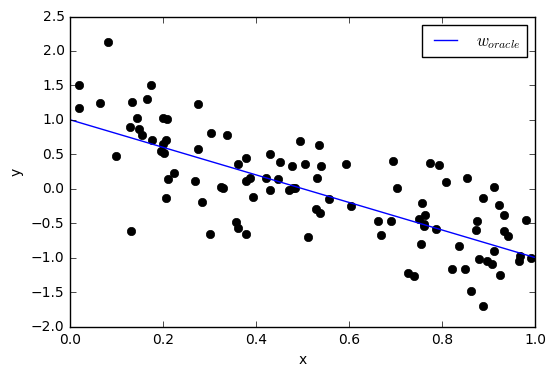

In [6]:
def fitted_line(w, x_lim, **plot_args):
    x_0, x_1 = x_lim
    y_0, y_1 = w[0] + w[1] * np.array(x_lim)
    plt.plot(x_lim, [y_0, y_1], **plot_args)
    
plt.plot(sample_xs.eval(), sample_ys.eval(), 'ko')
fitted_line(oracle_w, plt.xlim(), label='$w_{oracle}$')
plt.legend(); plt.xlabel('x'); plt.ylabel('y');

# Exercise

Write a procedure to return $\hat{\mathbf{w}}$ an estimator of $\mathbf{w}$ from our model, and plot the fitted model on the graph.
Many ways to achieve the results:

 * use a very high level wrapper from `sklearn` (look at LinearRegression or SgdRegressor)
 * use the numpy or tensorflow matrix inversion to solve analytically the OLS equation $ \hat{\mathbf{w}} = (\mathbf{X}^{T} \mathbf{X})^{-1} \mathbf{X}^{T} \mathbf{y}$
 * write a stochastic gradient procedure using tensorflow (https://github.com/aymericdamien/TensorFlow-Examples has a nice example)
 * For the brave, derive analytically the gradients and write you own SG or SGD 

In [79]:
# Parameters
learning_rate = 0.5
training_epochs = 100
display_step = 25

In [88]:
# tf Graph Input
train_X = x1
train_Y = sample_ys.eval()
X = tf.placeholder("float")
Y = tf.placeholder("float")

# Set model weights
W = tf.Variable(np.random.randn(), name="weight")
b = tf.Variable(np.random.randn(), name="bias")
sess.run(W.initializer)
sess.run(b.initializer)

In [89]:
# Construct a linear model
pred = tf.add(tf.mul(X, W), b)

# Mean squared error
cost = tf.reduce_sum(tf.pow(pred-Y, 2))/(2*n_samples)

# Gradient descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

# Initializing the variables
init = tf.initialize_all_variables()

In [90]:
for epoch in range(training_epochs):
    # feeding the full training set for every epoch
    # (as opposed to the example code which very inefficiently was feeding sample by sample)
    sess.run(optimizer, feed_dict={X: train_X, Y: train_Y})

    if (epoch) % display_step == 0:
        c = sess.run(cost, feed_dict={X: train_X, Y: train_Y})
        print("Epoch: {:4d}, cost={:.4f} W={:.2f} b={:.2f}".format(epoch, c, sess.run(W), sess.run(b)))

Epoch:    0, cost=0.1884 W=-0.71 b=0.32
Epoch:   25, cost=0.1348 W=-1.41 b=0.71
Epoch:   50, cost=0.1240 W=-1.72 b=0.89
Epoch:   75, cost=0.1219 W=-1.86 b=0.96


In [91]:
w_fitted = [sess.run(b), sess.run(W)]

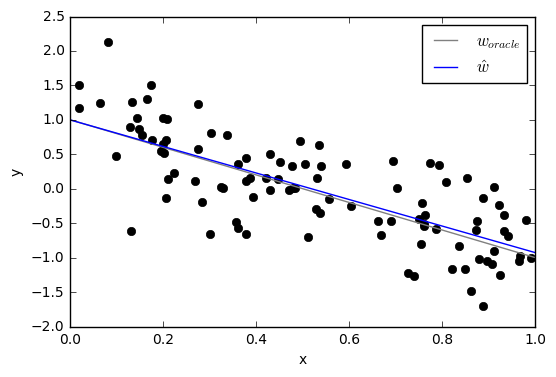

In [92]:
plt.plot(sample_xs.eval(), sample_ys.eval(), 'ko')
fitted_line(oracle_w, plt.xlim(), label='$w_{oracle}$', color='grey')
fitted_line(w_fitted, plt.xlim(), label='$\hat{w}$')
plt.legend(); plt.xlabel('x'); plt.ylabel('y');